In [74]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import scipy.spatial.distance as spd

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import sklearn as sk
import sklearn.cluster as skc
import sklearn.metrics as skm
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from string import ascii_letters
import seaborn as sns

from __future__ import print_function

from statsmodels.stats.outliers_influence import variance_inflation_factor

import PIL
from  PIL  import Image

**2018-2019 NBA Player Cluster**

The NBA is an evolving league. Within the last 10 years, what is expected from a profession player has changed. Players were defined by their positions: Point Guard, Shooting Guard, Small Forward, Power Forward, and Center. A center stood by the net and only dunked. A point guard was short, fast, and looked to pass first. A shooting guard was to try to get open to take a shot. These positions are still in use today but how would you define a player like Dirk Nowitzki, a seven-footer who is 11th all time is three pointers. Or Kevin Durant, a seven-footer who will be known as one of the best scorers of all time and he scores everywhere on the court. Another example is Giannis Antetokounmpo, another seven-footer who is one of the primary ball handlers for his team. What position do you assign these players, would they be centers, point guards, shooting guards? This paper is an investigation into trying to use k-means clustering to define new position based on play stats.

**Questions Asked**  
1. Can new NBA positions be defined using k-means clustering?  
2. Do these positions make sense?  
3. Are the best players in the western conference?  
4. What team has the best player?  
5. Can these positions identify the prime age range of a player?

**Question 1: Can new NBA positions be defined using k-means clustering?**  
The data was collected online from Basketball Reference. The data is from the current 2018-2019 season. The data includes basic stats (points, rebound, steals, etc.) and advance stats (WS, VORP, PER, etc.). The visualization below is the correlation matrix between the of the data considered for the clustering.

In [43]:
nbadata = pd.read_excel('Nba Data.xlsx')

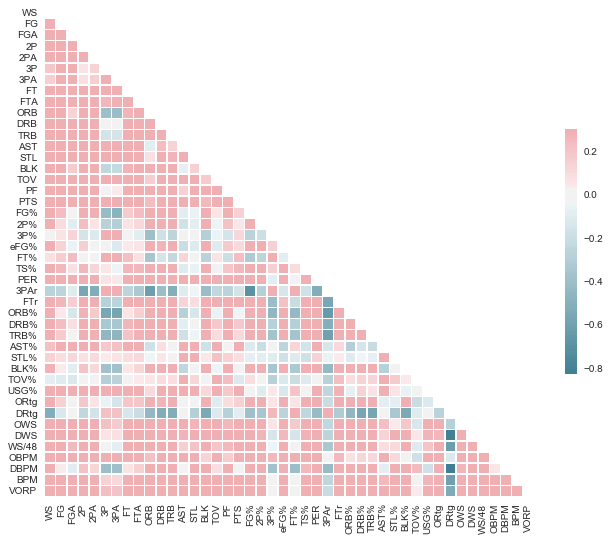

In [8]:
sns.set(style="white")

# Compute the correlation matrix
corr = nbadata.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

This matrix helped determined which stats were removed. If two stats had a correlation value greater than .8, one of them were removed from the dataset. Below you can see the correlation matrix for the final stats used to determine clusters.

In [44]:
nbadata2 = nbadata.iloc[:,1:]

In [10]:
def get_redundant_pairs(nbadata2):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = nbadata2.columns
    for i in range(0, nbadata2.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(nbadata2, n=5):
    au_corr = nbadata2.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(nbadata2)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [45]:
nbadata3 = nbadata2.drop(['3PA', 'FTA','2PA', 'FGA', 'DRB%','BPM','eFG%', 'AST%', 'BLK%', 'ORB%', 'DRB%', 
                          'ORtg','DRtg', 'DBPM', 'OBPM','DRB','WS/48','TRB%', 'OWS','ORB', 'STL%', '3P%', 'FG', 'WS', 'PTS'], axis=1)

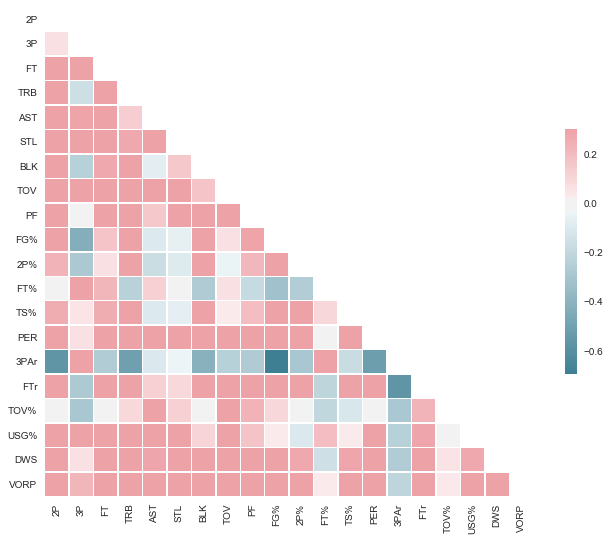

In [12]:
# Compute the correlation matrix
corr = nbadata3.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The data was then standardized, and principle components analysis was used to try to help with the clustering. The graph below shows the percentage of the variance capture at each principle component. Ideally, two principle components captures enough of the variance to be able to conveniently project the data onto a 2-D visualization. However, in this the first two principle components capture only 57% of the variance within the data. At 8 principle components, 90% of the data was captures, therefore 8 principle components were used

In [13]:
%%HTML
<div class='tableauPlaceholder' id='viz1550120556995' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;EV&#47;EV_7&#47;ExplainedVariance&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='EV_7&#47;ExplainedVariance' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;EV&#47;EV_7&#47;ExplainedVariance&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1550120556995');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

The next step was to determine how many clusters the data should be separated into. Two approaches were used in deciding this, the Elbow Test and the Silhouette Test. The Elbow Test below identified possibly using 6 or 8 clusters.

In [46]:
min_max_scaler = preprocessing.MinMaxScaler()
scalenba = min_max_scaler.fit_transform(nbadata3)

In [47]:
pcanba = PCA(n_components=20).fit(scalenba)

In [48]:
pcdf = PCA(n_components=8)
principalComponents = pcdf.fit_transform(scalenba)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1','principal component 2','principal component 3','principal component 4','principal component 5','principal component 6','principal component 7','principal component 8'])

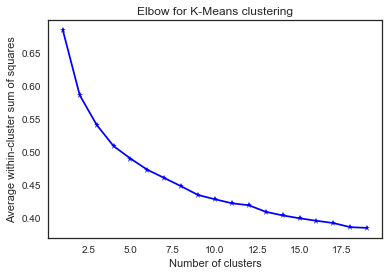

In [49]:
K = range(1,20)  # Apply kmeans 1 to 20
kmeans_models = [skc.KMeans(k).fit(principalDf) for k in K]
centroids = [m.cluster_centers_ for m in kmeans_models]
D_k = [spd.cdist(principalDf, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/principalDf.shape[0] for d in dist]

# plot elbow curve
plt.plot(K, avgWithinSS, 'b*-')
plt.xlabel('Number of clusters');
plt.ylabel('Average within-cluster sum of squares');
plt.title('Elbow for K-Means clustering');

Another method of identifying the correct number of clusters to use was the Silhouette test. Below shows the silhouette test for 6, 7, and 8 clusters. 

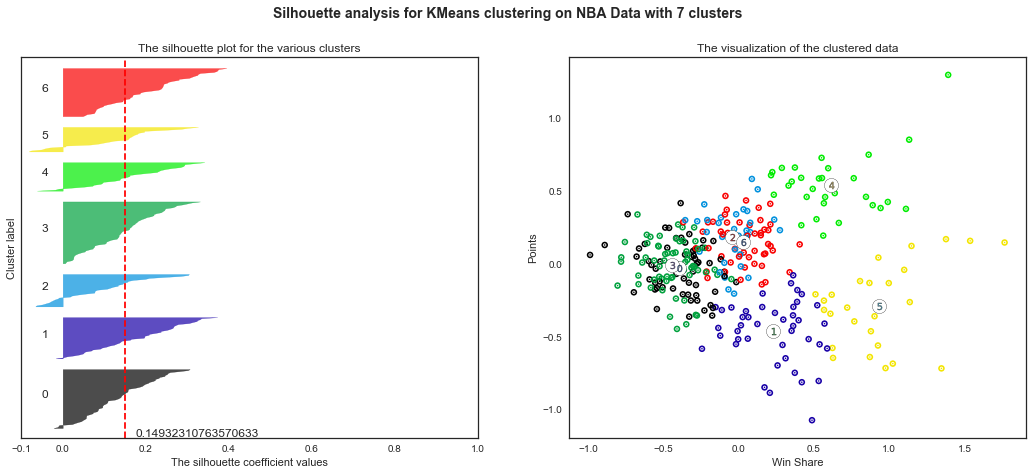

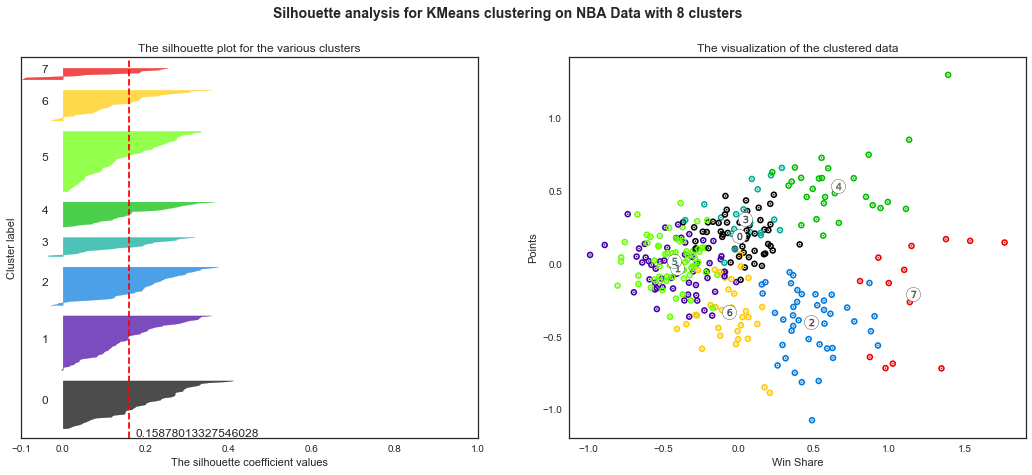

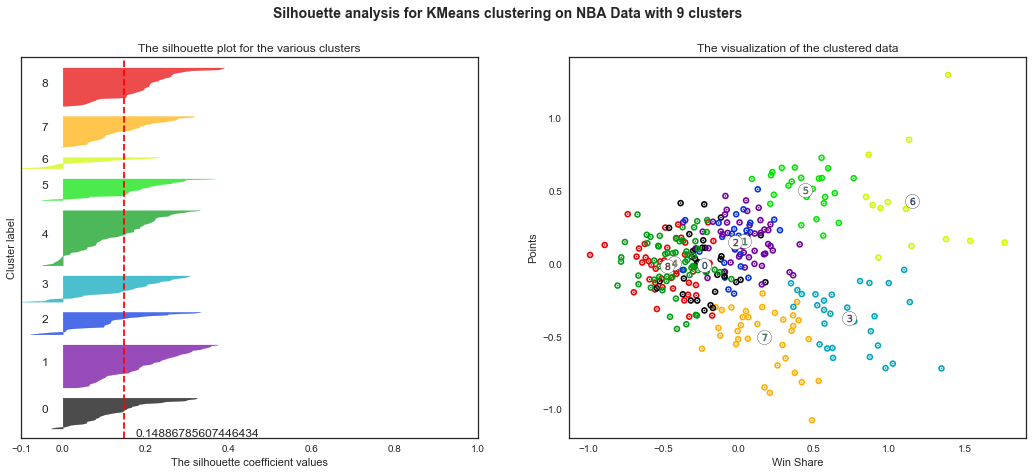

In [50]:
range_n_clusters = (7,8,9)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(principalDf) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(principalDf)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(principalDf, cluster_labels)
    silhouette_avg = silhouette_score(principalDf, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.text(0.175,1,silhouette_avg,alpha=1)

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(principalDf.iloc[:, 0], principalDf.iloc[:, 1], marker='.', s=10, lw=5, alpha=1,
                c=colors, edgecolor='face')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data")
    ax2.set_xlabel("Win Share")
    ax2.set_ylabel("Points")

    plt.suptitle(("Silhouette analysis for KMeans clustering on NBA Data " "with %d clusters" % n_clusters),fontsize=14, fontweight='bold')

plt.show()

From the results of the Elbow Test and the Silhouette Test, 8 clusters were chosen. After running the k means clustering code, the players were separated in the following 8 clusters:  
**Cluster 1: Superstars** – Can do almost everything at an elite level  
Highlighted by James Harden, Paul George, Stephen Curry, and Kawhi Leonard  

**Cluster 2: Elite Big** – The best big man in the NBA  
Highlighted by Giannis Antetokounmpo, Rudy Gobert, and Anthony Davis 

**Cluster 3: 3 and D ** – Players who specialize in hitting 3’s and defense  
Highlighted by: Danny Green, Robert Covington, and P.J. Tucker  

**Cluster 4: Shooters** –They know how to put the ball in the hoop  
Highlighted by: Tobias Harris, Malcolm Brogdon, and Buddy Hield  

**Cluster 5: Ballhandlers** – Players that help run an offense  
Highlighted by: Fred VanVleet, Cory Joseph, Shaun Livingston, and Lance Stephenson  

**Cluster 6: Playmakers** – Expect them to make the right pass  
Highlighted by: Kyle Lowry, Chris Paul, Lonzo Ball, and Ricky Rubio  

**Cluster 7: Rebounders** – Can control the glass  
Highlighted by: Ed Davis, Taj Gibson, Enes Kanter, and Jonas Valanciunas  

**Cluster 8: Benchwarmers** – They are still millionaires, do not feel bad for them  
Highlighted by:  Doug McDermott, Pat Connaughton, Meyers Leonard and Kyle Korver


The clusters made did have a lot of overlap and they are not perfect. With more data, the clusters may be able to be defined better and reduce the overlap. Also, different clustering techquies may result in better clusterings. 

**Question 2: Do these positions make sense?**  
Do these clusters make sense? Should I expect the superstars and the elite bigs to have the best stats? Are the rebounders averaging the most rebounds? Are the scorers scoring? The following visualizations compares the stats between the clusters.

In [63]:
%%HTML
<div class='tableauPlaceholder' id='viz1550126138146' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Po&#47;Points_7&#47;PTS&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Points_7&#47;PTS' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Po&#47;Points_7&#47;PTS&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1550126138146');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [64]:
%%HTML
<div class='tableauPlaceholder' id='viz1550126276648' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Re&#47;Rebounds_0&#47;Rebounds&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Rebounds_0&#47;Rebounds' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Re&#47;Rebounds_0&#47;Rebounds&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1550126276648');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [65]:
%%HTML
<div class='tableauPlaceholder' id='viz1550126377037' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;As&#47;Assists_0&#47;Assists&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Assists_0&#47;Assists' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;As&#47;Assists_0&#47;Assists&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1550126377037');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [66]:
%%HTML
<div class='tableauPlaceholder' id='viz1550126469152' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;VO&#47;VORP&#47;VORP&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='VORP&#47;VORP' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;VO&#47;VORP&#47;VORP&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1550126469152');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

The clusters do make sense when compared to stats. The superstars and the elite bigs tend to be the best in most categories, while the appropriate cluster for each categories (i.e. rebounders and rebounding) perform well.

**Question 3: Are the best players in the western conference?**  
The NBA is known for the Western conference being dominate compared to the Eastern. Do these clusters explain why? Are their more superstars and elite bigs in the west?

In [68]:
%%HTML
<div class='tableauPlaceholder' id='viz1550126908915' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Co&#47;Conferences_4&#47;Cof&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Conferences_4&#47;Cof' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Co&#47;Conferences_4&#47;Cof&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1550126908915');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

The West has 3 more superstars and 1 more elite big than the East. Each conference has about the same about of shooters, 3 and D players, rebounders, and playmakers. The East has much more ballhandlers then the West and the West has much more benchwarmers then the East. The disceprancy in superstars and elite bigs can play a role in why the West is know as the dominate conference, however I expect there is also other factors that effect this.

**Question 4: What team has the best player?**  
Two clusters clearly were made up of the ebst players, the superstar and the elite big clusters. Which teams have the most superstars and elite bigs? Does this relate to the teams that are performing the best this year?

In [72]:
%%HTML
<div class='tableauPlaceholder' id='viz1550127350126' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;Teams_5&#47;Teams&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Teams_5&#47;Teams' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;Teams_5&#47;Teams&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1550127350126');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

The Toronto Raptors have the most amount of superstars and elite bigs. The ranking of teams based off of superstars and elite bigs does not mirror the teams season performance but is not a bad judgement. More refined clusters or creating a new cluster such as “Second-Option” and including that in the sorting may result in a more accurate team ranking.

**Question 5: Can these positions identify the prime age range of a player?**  
Can you look at the ages of the superstars and the elite bigs to identify a prime for each player type?

In [73]:
%%HTML
<div class='tableauPlaceholder' id='viz1550127763205' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Pr&#47;Prime_0&#47;Age&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Prime_0&#47;Age' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Pr&#47;Prime_0&#47;Age&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1550127763205');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

From the graph above it appears that superstars are most common at the age range of 28-30, indicating when a player reaches their prime. Elite bigs have a different prime of between the ages of 24 and 25. Elite bigs primes could be so young because of how heavily bigs depend on their athleticism.

**Conclusion**  
The clusters made from the NBA did perfrom decently well when they were compared to stats, however they did have issues with them. Having more data could result in more accurate clusters. Different clusting methods may also result in stronger clusters. The technique does work well with NBA players. How players are positioned now is from 100 years ago, it needs to be updated to reflect the change in the game.  
Clustering could be used to identify what makes a winning team. What are the previous champship teams made up of? Are rebounders and 3 and D players under appreciated? Or do you just need as much top end talent as possible?  
If you include NCAA and Europe league players into the dataset could you potential identify superstars in the making?

In [225]:
kmeans_model = skc.KMeans(n_clusters=8)
kmeans_model.fit(scalenba)
centroids = kmeans_model.cluster_centers_

In [226]:
nbadata3['cluster_labels_kmeans'] = kmeans_model.labels_

In [141]:
nbadata['cluster'] = kmeans_model.labels_

In [191]:
nbadata.loc[nbadata['cluster'] == 0, 'cluster'] = 'Shooter'

In [194]:
cluster0 = nbadata[(nbadata.cluster== 'Shooter')]

In [159]:
nbadata.loc[nbadata['cluster'] == 1, 'cluster'] = 'Superstar'

In [195]:
cluster1 = nbadata[(nbadata.cluster=='Superstar')]

In [161]:
nbadata.loc[nbadata['cluster'] == 2, 'cluster'] = 'Rebounder'

In [196]:
cluster2 = nbadata[(nbadata.cluster== "Rebounder")]

In [163]:
nbadata.loc[nbadata['cluster'] == 3, 'cluster'] = 'Ballhandlers'

In [197]:
cluster3 = nbadata[(nbadata.cluster=='Ballhandlers')]

In [165]:
nbadata.loc[nbadata['cluster'] == 4, 'cluster'] = 'Elite Big'

In [198]:
cluster4 = nbadata[(nbadata.cluster=='Elite Big')]

In [167]:
nbadata.loc[nbadata['cluster'] == 5, 'cluster'] = '3 and D'

In [199]:
cluster5 = nbadata[(nbadata.cluster=='3 and D')]

In [169]:
nbadata.loc[nbadata['cluster'] == 6, 'cluster'] = 'Playmaker'

In [200]:
cluster6 = nbadata[(nbadata.cluster=='Playmaker')]

In [171]:
nbadata.loc[nbadata['cluster'] == 7, 'cluster'] = 'Benchwarmers'

In [201]:
cluster7 = nbadata[(nbadata.cluster=='Benchwarmers')]

In [181]:
writer = pd.ExcelWriter('NBAClusters.xlsx', engine='xlsxwriter')

In [182]:
nbadata.to_excel(writer, sheet_name='Sheet1')